First, load the data,in this notebook we are using the PMI data from the paper:"Environmental predictors impact microbialbased postmortem interval (PMI) estimation models within human decomposition soils". The preprocessed data includes OTU/phylum/class/order abundance matrices (includes or not include environmental factors)

In [2]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric



In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle
import matplotlib.pyplot as plt
import glob
import os

In [4]:
PMIdata_path = '../data/count_table/'

## No env model
16s (OTU/phylum/class/order) - no env

ITS (OTU/phylum/class/order) - no env

16s+ITS (OTU/phylum/class/order) - no env (only use this data when calculating H)
bact.ITS.n.class.env

### Data preprocess


In [5]:
bact_ITS_noenv_files = glob.glob(PMIdata_path + 'bact.ITS.n.*.noenv.csv')


In [6]:
bact_ITS_noenv_files

['../data/count_table/bact.ITS.n.otu.noenv.csv',
 '../data/count_table/bact.ITS.n.class.noenv.csv',
 '../data/count_table/bact.ITS.n.order.noenv.csv',
 '../data/count_table/bact.ITS.n.phylum.noenv.csv']

In [7]:
# Read each CSV file into a list of dataframes
bact_ITS_noenv_df_list = [pd.read_csv(file) for file in bact_ITS_noenv_files]

In [8]:
for df in bact_ITS_noenv_df_list:
    print(df.shape)

(78, 7415)
(78, 178)
(78, 412)
(78, 52)


In [9]:
bact_ITS_noenv_df_list[3]
for df in bact_ITS_noenv_df_list:
    data = df.drop(df.columns[0], axis=1)
    print(data)

      Otu00001     Otu00002  Otu00003    Otu00004    Otu00005    Otu00006  \
0     0.000000     0.000000  0.000000  270.801005  208.868321  293.047335   
1   249.850550    12.415886  0.153283  225.018777  149.910330  224.405647   
2    22.804314     1.232666  0.000000  114.637904   92.039034  137.031330   
3    82.019517     0.778174  0.000000  129.488117   94.625932  137.736759   
4    21.808789     0.852858  0.000000  130.974573  100.393533  196.766451   
..         ...          ...       ...         ...         ...         ...   
73    0.137474     0.000000  0.000000  257.351425  347.396929  294.881841   
74    4.193263     1.708366  0.465918  182.639892  100.017084  118.498501   
75   29.378020  1493.585509  1.564510  196.259083  191.739387  255.362792   
76  176.288607   157.368583  1.150542  256.954387  258.616281  393.357537   
77   69.217111   391.444266  0.554847  195.860844  196.831826  252.177773   

      Otu00007    Otu00008    Otu00009   Otu00010  ...  ITS03273   ITS03351

In [9]:
data_4taxa = []
col_names_4taxa = []
for df in bact_ITS_noenv_df_list:
    data = df.drop(df.columns[0], axis=1)
    cols_name = data.columns.tolist()
    data = data.values
    data =FS.relative_abundance(data)
    data_4taxa.append(data)
    col_names_4taxa.append(cols_name)

In [10]:
# target variable
y = bact_ITS_noenv_df_list[3].iloc[:, 0].values 
y

array([   0.     , 1484.147  , 1989.56009, 2973.68   , 4027.69203,
          0.     , 1026.394  , 1423.473  ,  214.938  ,  493.696  ,
          0.     , 1543.201  , 2970.8    , 3542.968  ,    0.     ,
       1445.51502, 2962.59226, 3504.55394, 4583.2796 ,    0.     ,
       2639.949  , 3573.444  ,    0.     , 1507.78   , 3103.803  ,
       4567.716  ,    0.     , 1510.142  , 2847.791  , 4578.995  ,
          0.     , 1589.377  , 3031.373  , 4512.836  ,    0.     ,
       1502.226  , 3019.923  , 4574.528  ,    0.     , 1364.604  ,
       3009.054  , 3407.734  ,    0.     , 1530.639  , 2949.689  ,
       4391.578  ,    0.     , 1588.226  , 3011.635  , 3976.49   ,
          0.     , 1445.393  , 2999.732  , 4527.275  ,    0.     ,
       1532.17172, 3552.96112, 4474.30808,    0.     , 1329.627  ,
       2854.888  , 4326.392  ,    0.     , 1600.15   , 3024.861  ,
       3985.61   ,    0.     , 1087.43   , 1533.552  ,  510.076  ,
          0.     , 1500.02566, 2988.04838, 4447.32241,    0.  

In [11]:
# Define the threshold
y_threshold = 2500

# Categorize the series based on the threshold
y = np.where(y > y_threshold, 'LONG', 'SHORT')

print(y)

['SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT'
 'SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'LONG' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'LONG'
 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG']


In [12]:
list(y).count('LONG')

35

In [13]:
list(y).count('SHORT')

43

#### OTU

##### 1. calculate H statistics for OTU/phylum/class/order (both 16s and ITS)

In [14]:
weights_4taxa = []

In [15]:
for df in data_4taxa:
    print(np.shape(df))
    weights=FS.OTU_H_Score_fun(df,y)
    weights_4taxa.append(weights)
    

(78, 7414)
(78, 177)
(78, 411)
(78, 51)


In [16]:
for weight in weights_4taxa:
    print(len(weight))

7414
177
411
51


In [17]:
max(weights_4taxa[3])

34.26918116083644

In [18]:
selectedOTU_index_4tax = []
eps_4tax = []

In [19]:
for weight in weights_4taxa:
    selectedOTU_index, eps=FS.indice_H_unisig(weight,y)
    print(eps)
    selectedOTU_index_4tax.append(selectedOTU_index)
    eps_4tax.append(eps)
    

23
26
34
13


##### 2. Select indices of the features based on H statistics and form the subset based on the selected features.
The default p value of the function is 10%, the resulted index is ranked by its H statistics descendingly.

Use "indice_H_unisig" if there is only one response, use "indice_H_multisig" for multiple responses.

weights_4taxa,selectedOTU_index_4tax,col_names_4taxa,eps_4tax

In [20]:
weights_sig_sorted_4taxa = []
col_names_sig_sorted_4taxa = []
for i in range(len(weights_4taxa)):
    weights_sig_sorted = weights_4taxa[i][selectedOTU_index_4tax[i]]
    col_names_sig_sorted = [col_names_4taxa[i][j] for j in selectedOTU_index_4tax[i]]
    weights_sig_sorted_4taxa.append(weights_sig_sorted)
    col_names_sig_sorted_4taxa.append(col_names_sig_sorted)

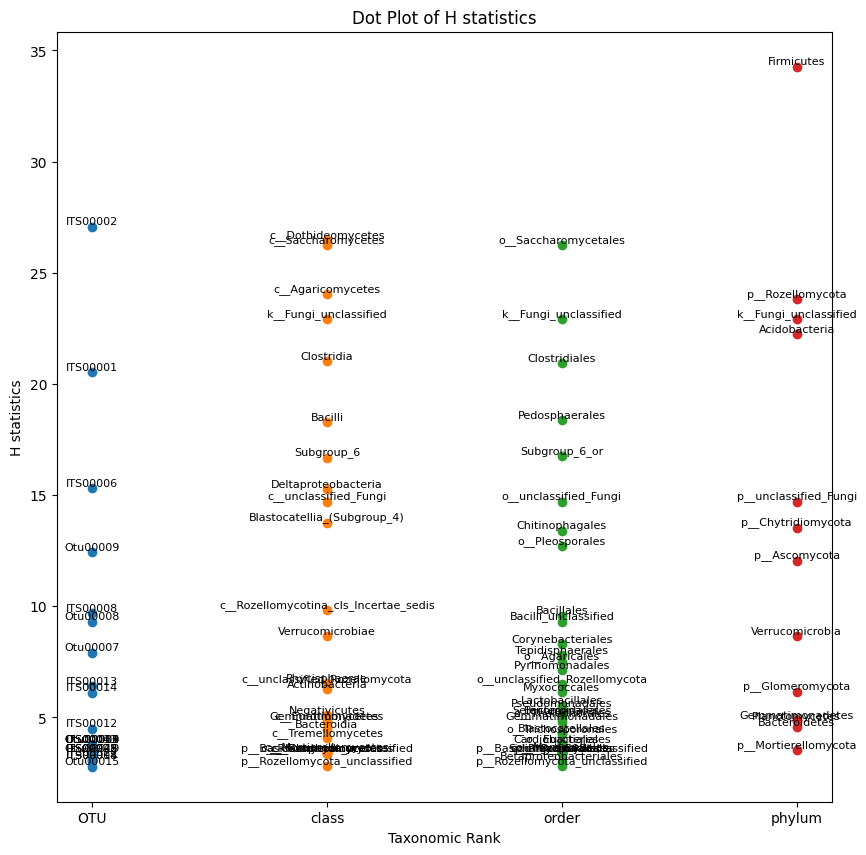

In [21]:
taxlabels = ['OTU', 'class', 'order', 'phylum']

# Assuming weights_sig_sorted_4taxa contains numeric arrays
# Ensure col_names_sig_sorted_4taxa contains the corresponding string labels for each point

plt.figure(figsize=(10, 10))
for i, array in enumerate(weights_sig_sorted_4taxa):
    x_values = [taxlabels[i]] * len(array)  # Label each point with its group (e.g., 'OTU', 'class', etc.)
    plt.scatter(x_values, array, label=f'{taxlabels[i]}')
    
    # Annotate each point with its name from col_names_sig_sorted_4taxa[i][j] and its value
    for j, z in enumerate(array):
        label = col_names_sig_sorted_4taxa[i][j]  # Get the corresponding label for this point
        plt.text(taxlabels[i], z, label, ha='center', va='bottom', fontsize=8, color='black')

plt.title('Dot Plot of H statistics')
plt.xlabel('Taxonomic Rank')
plt.ylabel('H statistics')
plt.show()

In [22]:
#plot the h statistics and cutoff descendingly
#for i in range(len(weights_4taxa)):
    #FS.plotWeightedIndex(weights_4taxa[i],threshold=eps_4tax[i])

In [23]:
data_4taxa[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01289198, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.07645873, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01990668, 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### 4. Model
Prepare 4 datasets: full dataset, our selected dataset, Lasso selected  dataset(based on the target variable), randomly selected data (selected the same numer of variables as in our method)

Use random forest and SVM as classifier, and will build both models for each response variable.

For Lasso, the dataset will be determined by the response variable, so the lasso subset is different for the models for different response variables.

For random selection, the  process will repeat iter=30 times to  find the mean accuracy and AUC

SMOTE  is used (the data is not balanced, as we can see the performance is really bad especially for SVM model when not using SMOTE)

In [24]:
iter =30
cls = ["RF","SVM"]

In [25]:
targetLabel=y

In [26]:
data_subset_4taxa = []
X_lasso_4taxa = []
X_lasso_ft_4taxa = []
xind_lasso_4taxa = []
xind_lasso_ft_4taxa = []
for i, data  in enumerate(data_4taxa):
    X_lasso,xind_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)
    X_lasso_ft,xind_lasso_ft = RunML_continue.LassoFS_CV(data,targetLabel)
    X_lasso_4taxa.append(X_lasso)
    X_lasso_ft_4taxa.append(X_lasso_ft)
    xind_lasso_4taxa.append(xind_lasso)
    xind_lasso_ft_4taxa.append(xind_lasso_ft)
    data_subset = {"AllFeatures":data, 
                "SelectMicro": data[:,selectedOTU_index_4tax[i]],
                "Lasso":X_lasso,
                "Lasso_finetune":X_lasso_ft,
                "Random":data
              }
    data_subset_4taxa.append(data_subset)

Best alpha: 0.1
Best alpha: 0.05
Best alpha: 0.1
Best alpha: 0.05


In [57]:
for dataset  in data_subset_4taxa:
    data_subset = dataset
    for datatype, subset in data_subset.items():
        print(np.shape(subset))

(78, 7414)
(78, 23)
(78, 32)
(78, 6)
(78, 7414)
(78, 177)
(78, 26)
(78, 14)
(78, 14)
(78, 177)
(78, 411)
(78, 34)
(78, 20)
(78, 6)
(78, 411)
(78, 51)
(78, 13)
(78, 6)
(78, 6)
(78, 51)


In [28]:
with open('../data/data_subset_4taxa_noenv_label_ft.pkl', 'wb') as file:
    pickle.dump(data_subset_4taxa, file)


The  function will print out the accuracy and AUC for each dataset using each classifier, and also will return the y_actual, y_predict, y_predprob for future use.

In [29]:
#dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

In [30]:
xind_lasso_4taxa

[array([   7,    8,   14,   17,   18,   59,   91,  157,  475,  487,  529,
        5196, 5199, 5200, 5202, 5204, 5207, 5213, 5219, 5221, 5222, 5248,
        5261, 5273, 5276, 5289, 5296, 5299, 5325, 5342, 5498, 5527]),
 array([  1,   7, 111, 113, 114, 116, 117, 119, 122, 123, 126, 129, 136,
        137]),
 array([  2,   5,   6,   8,   9,  32,  43,  63,  90, 264, 266, 270, 271,
        287, 290, 292, 293, 294, 312, 313]),
 array([ 2,  4, 37, 39, 40, 44])]

### compare the first 15 index by their present ratio

['ITS00002', 'ITS00001', 'ITS00006', 'Otu00009', 'ITS00008', 'Otu00008', 'Otu00007', 'ITS00013', 'ITS00014', 'ITS00012']
Validation passed: Dimensions are correct.
Long= 35, short = 43
        OTU  presence_pos  presence_neg
0  ITS00002      0.828571      0.279070
1  ITS00001      0.800000      0.279070
2  ITS00006      0.228571      0.627907
3  Otu00009      0.028571      0.348837
4  ITS00008      0.400000      0.116279
5  Otu00008      0.200000      0.000000
6  Otu00007      0.057143      0.302326
7  ITS00013      0.200000      0.023256
8  ITS00014      0.200000      0.023256
9  ITS00012      0.114286      0.302326


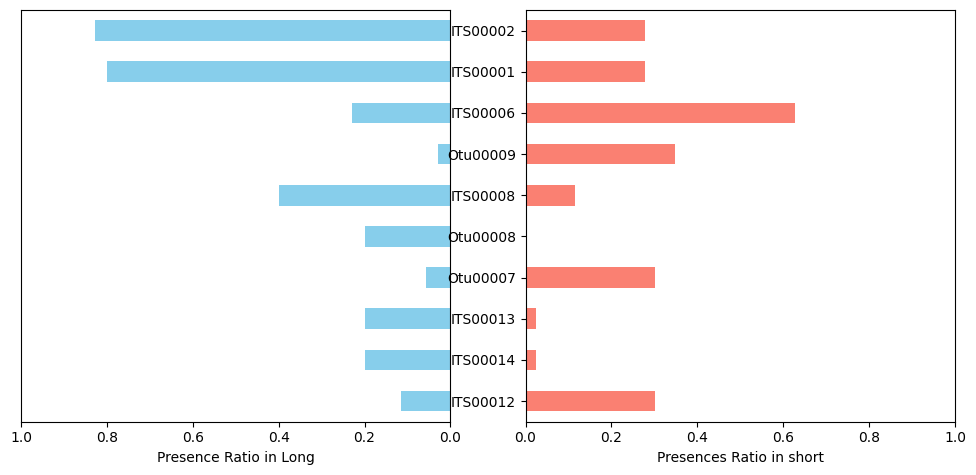

['c__Dothideomycetes', 'c__Saccharomycetes', 'c__Agaricomycetes', 'k__Fungi_unclassified', 'Clostridia', 'Bacilli', 'Subgroup_6', 'Deltaproteobacteria', 'c__unclassified_Fungi', 'Blastocatellia_(Subgroup_4)']
Validation passed: Dimensions are correct.
Long= 35, short = 43
                           OTU  presence_pos  presence_neg
0           c__Dothideomycetes      0.142857      0.720930
1           c__Saccharomycetes      0.885714      0.488372
2            c__Agaricomycetes      0.257143      0.790698
3        k__Fungi_unclassified      0.685714      0.953488
4                   Clostridia      0.600000      0.139535
5                      Bacilli      0.685714      0.279070
6                   Subgroup_6      0.885714      0.976744
7          Deltaproteobacteria      0.914286      0.976744
8        c__unclassified_Fungi      0.000000      0.348837
9  Blastocatellia_(Subgroup_4)      0.085714      0.465116


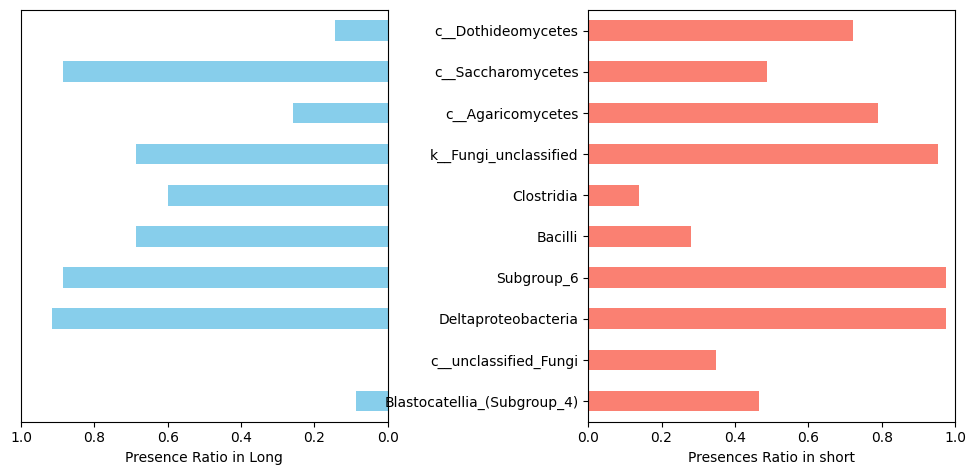

['o__Saccharomycetales', 'k__Fungi_unclassified', 'Clostridiales', 'Pedosphaerales', 'Subgroup_6_or', 'o__unclassified_Fungi', 'Chitinophagales', 'o__Pleosporales', 'Bacillales', 'Bacilli_unclassified']
Validation passed: Dimensions are correct.
Long= 35, short = 43
                     OTU  presence_pos  presence_neg
0   o__Saccharomycetales      0.885714      0.488372
1  k__Fungi_unclassified      0.685714      0.953488
2          Clostridiales      0.600000      0.139535
3         Pedosphaerales      0.000000      0.418605
4          Subgroup_6_or      0.885714      0.976744
5  o__unclassified_Fungi      0.000000      0.348837
6        Chitinophagales      0.314286      0.744186
7        o__Pleosporales      0.085714      0.441860
8             Bacillales      0.514286      0.209302
9   Bacilli_unclassified      0.200000      0.000000


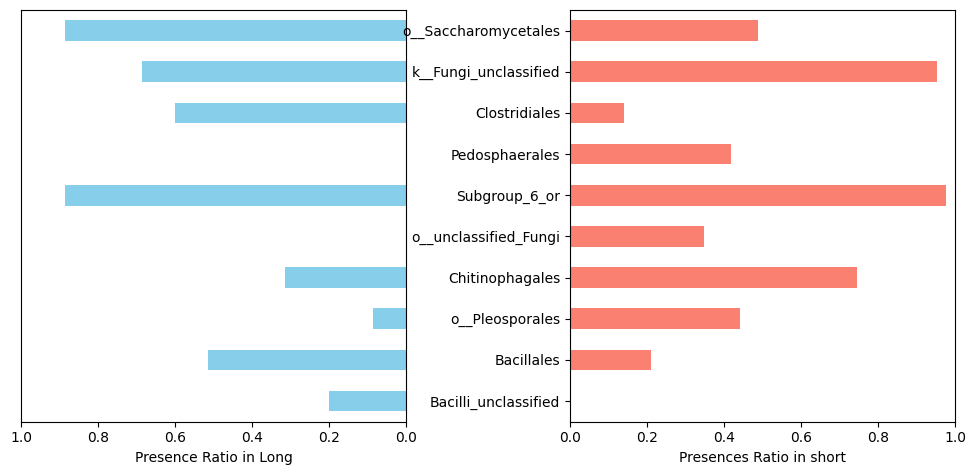

['Firmicutes', 'p__Rozellomycota', 'k__Fungi_unclassified', 'Acidobacteria', 'p__unclassified_Fungi', 'p__Chytridiomycota', 'p__Ascomycota', 'Verrucomicrobia', 'p__Glomeromycota', 'Gemmatimonadetes']
Validation passed: Dimensions are correct.
Long= 35, short = 43
                     OTU  presence_pos  presence_neg
0             Firmicutes      0.942857      0.418605
1       p__Rozellomycota      0.171429      0.767442
2  k__Fungi_unclassified      0.685714      0.953488
3          Acidobacteria      0.971429      1.000000
4  p__unclassified_Fungi      0.000000      0.348837
5     p__Chytridiomycota      0.000000      0.325581
6          p__Ascomycota      1.000000      1.000000
7        Verrucomicrobia      0.914286      0.976744
8       p__Glomeromycota      0.000000      0.162791
9       Gemmatimonadetes      0.057143      0.232558


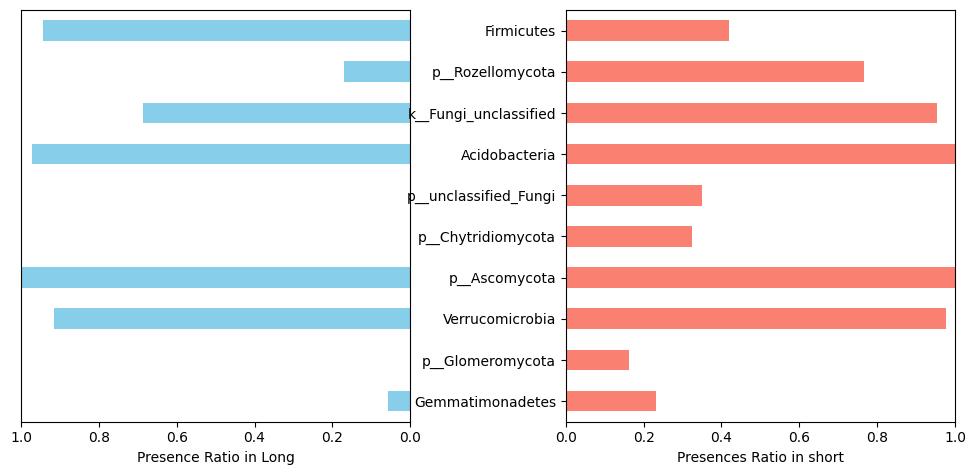

In [31]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

entries=10

for i, index in enumerate(selectedOTU_index_4tax):
    selectedOTU_index_15=index[:entries]
    #print(selectedOTU_index_15)
    selectedASVs_15=col_names_sig_sorted_4taxa[i][:entries]
    print(selectedASVs_15)
    X_FS_15=data_4taxa[i][:,selectedOTU_index_15]
    #df=pd.DataFrame(data=X_FS_15)
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")


In [32]:
##### check the plot results (use phylumn as example)
Phy_select_index = selectedOTU_index_4tax[3]
Phy_select_index_5 = Phy_select_index[0:5]
Phy_select_index_5

[4, 39, 38, 2, 44]

In [33]:
Phy_select_label_5 = [col_names_4taxa[3][i] for i in Phy_select_index_5]
print(Phy_select_label_5)
print(col_names_sig_sorted_4taxa[3][0:5])
print(weights_sig_sorted_4taxa[3][0:5])

['Firmicutes', 'p__Rozellomycota', 'k__Fungi_unclassified', 'Acidobacteria', 'p__unclassified_Fungi']
['Firmicutes', 'p__Rozellomycota', 'k__Fungi_unclassified', 'Acidobacteria', 'p__unclassified_Fungi']
[34.26918116 23.82576096 22.9256874  22.247891   14.69913199]


In [34]:
X_pyhlum = data_4taxa[3][:,Phy_select_index_5]
#X_pyhlum = np.where(X_pyhlum > 0.01, 1, 0)

In [35]:
# test 
data_phy_test=FS.relative_abundance(data_4taxa[3])
FS.OTU_H_Score_arr(data_phy_test[:,selectedOTU_index_4tax[3][0:5]],targetLabel)

array([34.26918116, 24.03590998, 23.1189484 , 21.58942765, 14.69913199])

In [36]:
print
for i in Phy_select_index_5:
    print(
    FS.OTU_H_Score(data_4taxa[3][:,i],targetLabel)
    )

34.26918116083644
23.825760958368498
22.92568740038021
22.247890996257183
14.699131985989982


In [37]:
print(weights_sig_sorted_4taxa[3])
print(weights_4taxa[3][selectedOTU_index_4tax[3]])

[34.26918116 23.82576096 22.9256874  22.247891   14.69913199 13.53380762
 12.04796669  8.66578317  6.16136704  4.87578408  4.84128675  4.55765047
  3.53086702]
[34.26918116 23.82576096 22.9256874  22.247891   14.69913199 13.53380762
 12.04796669  8.66578317  6.16136704  4.87578408  4.84128675  4.55765047
  3.53086702]


### Negative Gini Impurity
Gini Impurity is the probability of incorrectly classifying a randomly chosen element in the dataset if it were randomly labeled according to the class distribution in the dataset. It’s calculated as:

$G = 1- \sum_{i=1}^C p_i^2$

where C is the number of classes. (which means it can be used to measure for multiple level classification)

Here I will use the negative Gini Impurity to measure each OTU, if NG is large (1) which means the OTU only exist in one class, if NG value is small($1/c$) which means the OTU is evenly distributed among  the classes.

$NG = \sum_{i=1}^C p_i^2$

In [38]:
np.unique(y, return_counts=True)

(array(['LONG', 'SHORT'], dtype='<U5'), array([35, 43]))

In [39]:
# NG for selected OTU

NG_4tax = []
for i, data  in enumerate(data_4taxa):
    X_FS = data[:,selectedOTU_index_4tax[i]]
    X_lasso = data[:,xind_lasso_4taxa[i]]
    NG_selected = metric.Neg_GINI(X_FS,y)
    NG_Lasso = metric.Neg_GINI(X_lasso,y)
    print(NG_selected.shape)
    print(NG_Lasso.shape)
    NG_4tax.append([NG_selected,NG_Lasso])

(23,)
(32,)
(26,)
(14,)
(34,)
(20,)
(13,)
(6,)


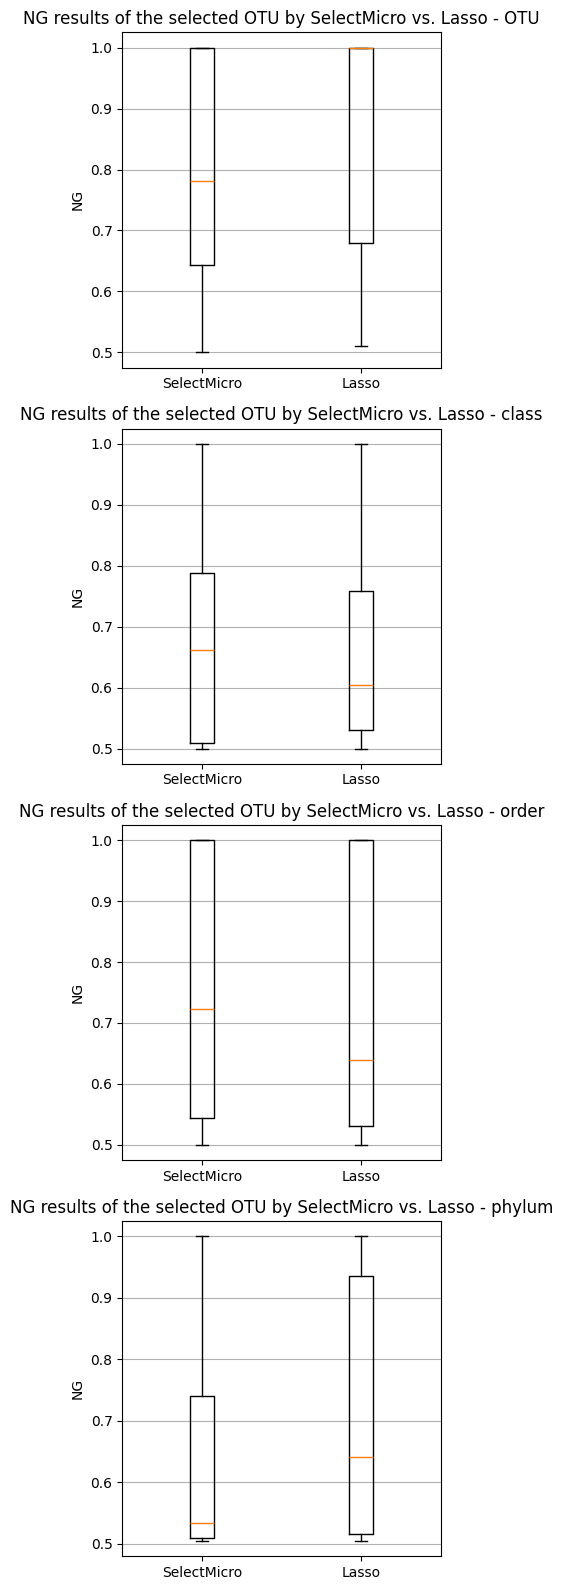

In [40]:
# compare the selected and non select by lasso
# Number of subplots
num_plots = len(data_4taxa)

# Create a figure with a grid of subplots
plt.figure(figsize=(4, 4 * num_plots))

# Loop through each index and create a subplot
for i in range(num_plots):
    plt.subplot(num_plots, 1, i + 1)  # (nrows, ncols, index)
    plt.boxplot([NG_4tax[i][0], NG_4tax[i][1]], tick_labels=['SelectMicro', 'Lasso'])
    plt.title(f'NG results of the selected OTU by SelectMicro vs. Lasso - {taxlabels[i]}')
    plt.ylabel('NG')
    plt.grid(axis='y')
# Adjust layout
plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()  # Show all plots at once

In [41]:
###  calculate the outlier label
NG_4tax_lasso =  [x[1] for x in NG_4tax]

In [42]:
NG_4tax_lasso

[array([1.        , 0.8828125 , 0.68      , 0.68      , 1.        ,
        0.68      , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.58596074, 0.625     , 0.64734694, 0.61218837,
        0.51020408, 0.78125   , 0.65432099, 0.68      , 0.625     ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ]),
 array([0.65432099, 0.55555556, 0.51849112, 0.500178  , 0.52987654,
        0.50832466, 0.53420118, 0.66901028, 0.75510204, 0.79238754,
        0.76080247, 0.55555556, 1.        , 1.        ]),
 array([0.65432099, 0.51135297, 1.        , 0.55555556, 0.625     ,
        1.        , 1.        , 0.51020408, 0.54081633, 0.51849112,
        0.50019223, 0.50832466, 0.53420118, 1.        , 0.55555556,
        1.        , 0.76446281, 1.        , 1.        , 1.        ]),
 array([0.50683083, 0.5432526 , 0.50439453, 0.73964497, 1.        ,
        1.        ])]

In [43]:
def Outlier_array(arr_input):
# Calculate Q1, Q3, and IQR
    Q1 = np.percentile(arr_input, 25)
    Q3 = np.percentile(arr_input, 75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Get the indices of outliers
    outlier_indices = np.where((arr_input < lower_bound) | (arr_input > upper_bound))[0]
    
    # Print the result
    return arr_input[outlier_indices],outlier_indices

In [44]:
NG_outlier_list = []
NG_outlier_label_list = []
for i, ng_lasso in enumerate(NG_4tax_lasso):
    NG_outlier, outlier_indice = FS.Outlier_array(ng_lasso)
    NG_outlier_list.append(NG_outlier)
    outlier_ind_origin = xind_lasso_4taxa[i][outlier_indice]
    ## the outlier indice is the indice  in the lasso data not in the original data
    outlier_label = [col_names_4taxa[i][j] for j in outlier_ind_origin]   
    NG_outlier_label_list.append(outlier_label)

In [45]:
print(NG_outlier_list)

[array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)]


In [46]:
print(NG_outlier_label_list)

[[], [], [], []]


In [47]:
# check the phylum outlier in lasso
outlier_ind_origin

array([], dtype=int64)

In [48]:
FS.OTU_H_Score_arr(FS.relative_abundance(data_4taxa[3]),targetLabel)[outlier_ind_origin]

array([], dtype=float64)

In [49]:
lasso_phylum_outlier_arr = FS.relative_abundance(data_4taxa[3])[:,outlier_ind_origin]

In [50]:
# Check if any element is larger than the threshold
result = (lasso_phylum_outlier_arr > 0.01).any()

print("Is there any value larger than the threshold?", result)

Is there any value larger than the threshold? False


#### Analysis of the top features

In [51]:
for i, label in enumerate(col_names_sig_sorted_4taxa):
    print(taxlabels[i])
    print(label)

OTU
['ITS00002', 'ITS00001', 'ITS00006', 'Otu00009', 'ITS00008', 'Otu00008', 'Otu00007', 'ITS00013', 'ITS00014', 'ITS00012', 'Otu00003', 'Otu00014', 'Otu00039', 'ITS00011', 'ITS00043', 'Otu00019', 'ITS00022', 'ITS00028', 'ITS00045', 'ITS00027', 'ITS00004', 'ITS00018', 'Otu00015']
class
['c__Dothideomycetes', 'c__Saccharomycetes', 'c__Agaricomycetes', 'k__Fungi_unclassified', 'Clostridia', 'Bacilli', 'Subgroup_6', 'Deltaproteobacteria', 'c__unclassified_Fungi', 'Blastocatellia_(Subgroup_4)', 'c__Rozellomycotina_cls_Incertae_sedis', 'Verrucomicrobiae', 'Phycisphaerae', 'c__unclassified_Rozellomycota', 'Actinobacteria', 'Negativicutes', 'c__Eurotiomycetes', 'Gemmatimonadetes', 'Bacteroidia', 'c__Tremellomycetes', 'c__Mortierellomycetes', 'c__Rhizophydiomycetes', 'p__Basidiomycota_unclassified', 'c__Glomeromycetes', 'c__Sordariomycetes', 'p__Rozellomycota_unclassified']
order
['o__Saccharomycetales', 'k__Fungi_unclassified', 'Clostridiales', 'Pedosphaerales', 'Subgroup_6_or', 'o__unclassif

In [52]:
targetLabel

array(['SHORT', 'SHORT', 'SHORT', 'LONG', 'LONG', 'SHORT', 'SHORT',
       'SHORT', 'SHORT', 'SHORT', 'SHORT', 'SHORT', 'LONG', 'LONG',
       'SHORT', 'SHORT', 'LONG', 'LONG', 'LONG', 'SHORT', 'LONG', 'LONG',
       'SHORT', 'SHORT', 'LONG', 'LONG', 'SHORT', 'SHORT', 'LONG', 'LONG',
       'SHORT', 'SHORT', 'LONG', 'LONG', 'SHORT', 'SHORT', 'LONG', 'LONG',
       'SHORT', 'SHORT', 'LONG', 'LONG', 'SHORT', 'SHORT', 'LONG', 'LONG',
       'SHORT', 'SHORT', 'LONG', 'LONG', 'SHORT', 'SHORT', 'LONG', 'LONG',
       'SHORT', 'SHORT', 'LONG', 'LONG', 'SHORT', 'SHORT', 'LONG', 'LONG',
       'SHORT', 'SHORT', 'LONG', 'LONG', 'SHORT', 'SHORT', 'SHORT',
       'SHORT', 'SHORT', 'SHORT', 'LONG', 'LONG', 'SHORT', 'SHORT',
       'LONG', 'LONG'], dtype='<U5')

In [53]:
phlyum_list = ['Firmicutes', 'Acidobacteria', 'Verrucomicrobia', 'Gemmatimonadetes', 'Bacteria_unclassified', 'Planctomycetes', 'Bacteroidetes', 'Entotheonellaeota', 'Patescibacteria']

In [54]:
indices = [col_names_4taxa[3].index(item) for item in phlyum_list if item in col_names_4taxa[3]]
indices

[4, 2, 1, 13, 12, 11, 5, 8, 21]

In [55]:
for i in indices:
    print(
    FS.OTU_H_Score(data_4taxa[3][:,i],targetLabel)
    )

34.26918116083644
22.247890996257183
8.665783167895457
4.875784083635615
0.8139534883724555
4.841286753665546
4.55765046815714
0
0


In [56]:
data_4taxa[3][:,21]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [59]:
def fisher_discriminant_ratio(features, labels):
    """
    Calculate the Fisher's discriminant ratio (F1) for an entire dataset.

    Parameters:
    - features: A 2D numpy array of feature values (samples x features).
    - labels: A 1D numpy array of class labels corresponding to the samples.

    Returns:
    - F1: Fisher's discriminant ratio for the dataset.
    """
    # Ensure features and labels are numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Get unique classes
    classes = np.unique(labels)
    if len(classes) != 2:
        raise ValueError("This implementation only supports two classes.")

    # Calculate class-wise means and overall mean
    overall_mean = np.mean(features, axis=0)
    class_means = [np.mean(features[labels == c], axis=0) for c in classes]

    # Calculate between-class scatter
    between_class_scatter = sum(
        len(features[labels == c]) * np.outer((class_mean - overall_mean), (class_mean - overall_mean))
        for c, class_mean in zip(classes, class_means)
    )

    # Calculate within-class scatter
    within_class_scatter = sum(
        sum(np.outer((sample - class_mean), (sample - class_mean)) for sample in features[labels == c])
        for c, class_mean in zip(classes, class_means)
    )

    # Compute Fisher's discriminant ratio
    F1 = np.trace(between_class_scatter) / np.trace(within_class_scatter)

    return F1

In [60]:

for datatype, subset in data_subset_4taxa[0].items():
    print(f"f1 of {datatype} = {fisher_discriminant_ratio(subset,targetLabel)}")
 

f1 of AllFeatures = 0.11001573153998669
f1 of SelectMicro = 0.1824057534954208
f1 of Lasso = 0.24210937729137938
f1 of Lasso_finetune = 0.36988708234793455
f1 of Random = 0.11001573153998669


In [61]:
for datatype, subset in data_subset_4taxa[1].items():
    print(f"f1 of {datatype} = {fisher_discriminant_ratio(subset,targetLabel)}")


f1 of AllFeatures = 0.2297476496121627
f1 of SelectMicro = 0.27018731598328394
f1 of Lasso = 0.33434739542998504
f1 of Lasso_finetune = 0.33434739542998504
f1 of Random = 0.2297476496121627


In [62]:
for datatype, subset in data_subset_4taxa[2].items():
    print(f"f1 of {datatype} = {fisher_discriminant_ratio(subset,targetLabel)}")


f1 of AllFeatures = 0.22390816584976964
f1 of SelectMicro = 0.28878888861154195
f1 of Lasso = 0.35736325231498683
f1 of Lasso_finetune = 0.4142877545767314
f1 of Random = 0.22390816584976964


In [63]:
for datatype, subset in data_subset_4taxa[3].items():
    print(f"f1 of {datatype} = {fisher_discriminant_ratio(subset,targetLabel)}")


f1 of AllFeatures = 0.16186376884683504
f1 of SelectMicro = 0.225994270936303
f1 of Lasso = 0.3071114522305581
f1 of Lasso_finetune = 0.3071114522305581
f1 of Random = 0.16186376884683504
